# Model creation

## feature selection, imputing, scaling and train test split

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

df = pd.read_csv('final_dataframe_churn_prediction.csv')

X = df.drop(columns=["is_churned"], axis = 1).copy()

y = df['is_churned'].copy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [3]:
X_train

,order_count_historic,gmv_historic,AOV_historic,antiquity_days,visits_count_3m,canceled_orders,tickets_finales,mean_order_lapse,new_skus_within_3m,orders_count_delta_1m,gmv_delta_1m,distinct_skus_delta_1m,orders_count_delta_2m,gmv_delta_2m,distinct_skus_delta_2m,warehouse_Bogota,sub_categoria_Ambientadores,sub_categoria_Complementos y vitaminas
1209,7,4.982586e+06,7.117980e+05,136,6,0,0,22.666667,5,0.000000,0.223456,0.181818,-0.800000,-0.673311,-0.555556,1.0,0.0,0.0
5244,130,1.793423e+07,1.379556e+05,454,21,0,0,3.519380,131,-0.235294,0.263366,0.072165,-0.268293,0.063617,-0.067039,1.0,0.0,0.0
3036,29,4.308398e+07,1.485654e+06,574,8,0,0,20.500000,72,0.000000,0.384690,0.350000,1.000000,0.230457,0.041322,1.0,0.0,0.0
1158,5,9.082359e+05,1.816472e+05,148,8,0,0,37.000000,5,0.000000,0.223456,0.181818,-0.666667,-0.765666,-0.687500,1.0,0.0,0.0
5204,178,7.668532e+07,4.308164e+05,417,34,0,0,2.355932,137,-0.133333,0.124538,0.016287,0.166667,-0.044767,0.022026,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3092,52,2.620833e+07,5.040064e+05,448,11,0,0,8.784314,22,-0.500000,-0.744108,-0.615385,0.500000,0.164743,-0.131579,0.0,0.0,0.0
3772,8,1.861974e+06,2.327468e+05,59,8,0,0,8.428571,61,0.000000,0.223456,0.181818,0.058824,0.211494,0.198953,1.0,0.0,0.0
5191,283,1.640629e+07,5.797276e+04,562,7,0,0,1.992908,21,-0.562500,-0.681850,-0.604651,-0.041667,-0.013422,0.268293,0.0,0.0,0.0
5226,407,4.802106e+07,1.179879e+05,535,12,0,0,1.317734,52,-0.720000,-0.152650,-0.100917,-0.111111,0.176199,0.190141,1.0,0.0,0.0


## Descripción de las variables

Nótese que cada registro describe las variables comportamentales de un cliente.

- is_churned: Variable objetivo, 1 indica que el cliente es un cliente actualmente 'churn', 0 indica que el cliente no es 'churn' en otras palabras está activo.
- order_count_historic: Conteo histórico de órdenes.
- gmv_historic: Sumatoria del gmv histórico (Gross Merchandise Value) en COP.
- AOV_historic: Average order value del cliente.
- antiquity_days: Días transcurridos desde la primera órden del cliente.
- visits_count_3m: Conteo de visitas de la empresa al cliente en los tres meses anteriores a su última compra.
- canceled_orders: Conteo de ordenes canceladas por parte del cliente.
- tickets_finales: Conteo de tickets abiertos por el cliente. Un ticket es un contacto con customer_service
- mean_order_lapse: Lapso promedio entre órdenes
- new_skus_within_3m: Cantidad de productos nuevos que el cliente compró en los tres meses previos a su última órden
- orders_count_delta_1m: Variación entre el conteo de órdenes del último més de actividad del cliente versus el més anterior. Se calcula como ordenes_ultimo_mes - ordenes_mes_anterior / ordenes_mes_anterior
- gmv_delta_1m: Variacion en el gmv (ultimo més de actividad)
- distinct_skus_delta_1m: Variacion en la cantidad de productos que se compra (ultimo més de actividad)
- orders_count_delta_2m: Variación entre el conteo de órdenes (dos últimos meses de actividad)
- gmv_delta_2m: Variacion en el gmv (dos últimos meses de actividad)
- distinct_skus_delta_2m: Variacion en la cantidad de productos que se compra (dos últimos meses de actividad)
- warehouse_Bogota: El cliente pertenece a la ciudad de Bogotá
- sub_categoria_Ambientadores: El cliente compra los productos de la sub categoría Ambientadores
- sub_categoria_Complementos y vitaminas: El cliente compra los productos de la sub categoría Complementos y vitaminas

## Testing all models without hyperparameter tuning

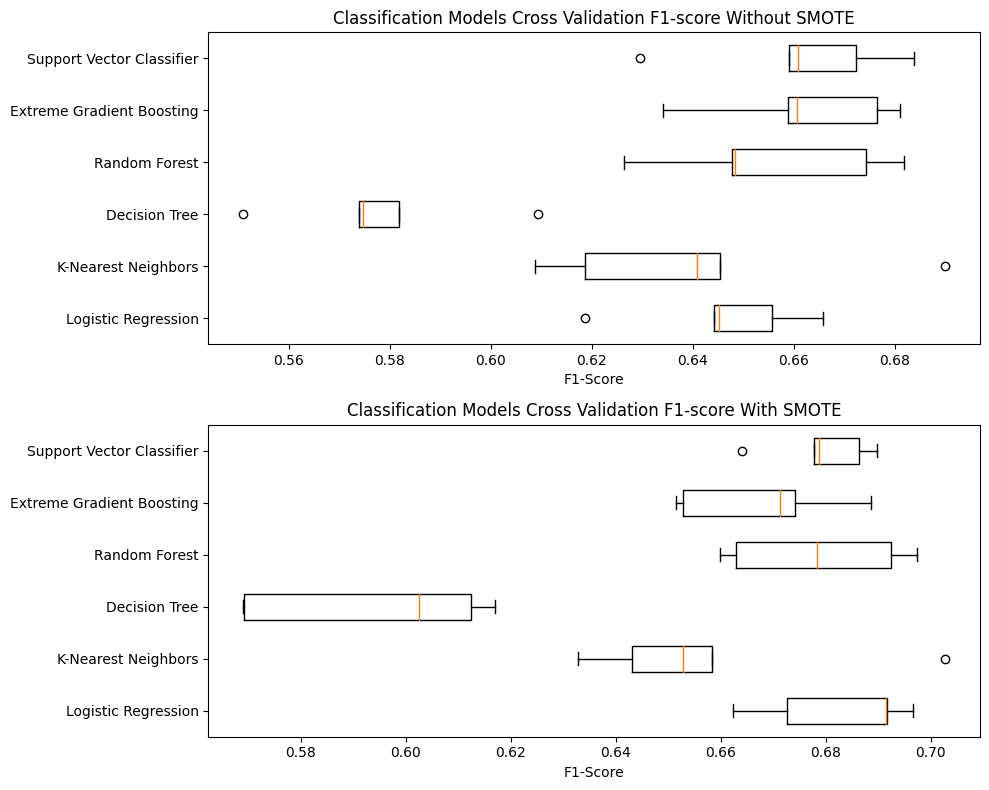

In [3]:
from sklearn.experimental import enable_iterative_imputer

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline

# Function to evaluate models
def evaluate_models(models, use_smote=False):
    results = []
    for name, model in models.items():
        
        # Set random_state to 42 if the classifier has this parameter
        if "random_state" in model.get_params().keys():
            model.set_params(random_state=42)
        
        steps = [
            ('imputer', IterativeImputer(random_state=0)),
            ('scaler', StandardScaler()),
            ('classifier', model)
            ]
        
        if use_smote:
            steps.insert(1, ('smote', SMOTE(random_state=42)))
            
        pipeline = ImbPipeline(steps) if use_smote else Pipeline(steps)
        
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring="f1")
        results.append(cv_scores)
    return results

# Models without SMOTE
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Extreme Gradient Boosting": xgb.XGBClassifier(),
    # "Support Vector Classifier": SVC(probability=True)  # 'probability=True' needed for scoring recall in SVC,
}

# Evaluate and plot for both scenarios
results_without_smote = evaluate_models(models, use_smote=False)

results_with_smote = evaluate_models(models, use_smote=True)

# Plotting the results
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].boxplot(results_without_smote, labels=models.keys(), vert=False)
axs[0].set_title('Classification Models Cross Validation F1-score Without SMOTE')
axs[0].set_xlabel('F1-Score')

axs[1].boxplot(results_with_smote, labels=models.keys(), vert=False)
axs[1].set_title('Classification Models Cross Validation F1-score With SMOTE')
axs[1].set_xlabel('F1-Score')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning

Model saved as KNN.pkl


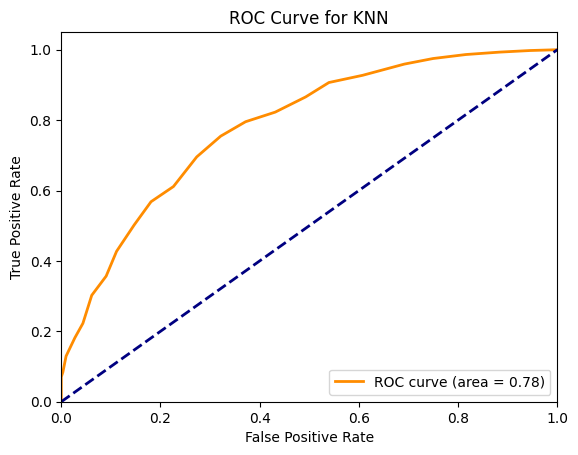

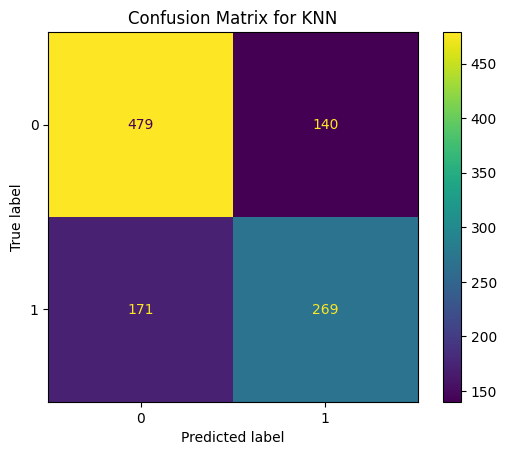

Model saved as KNN_with_SMOTE.pkl


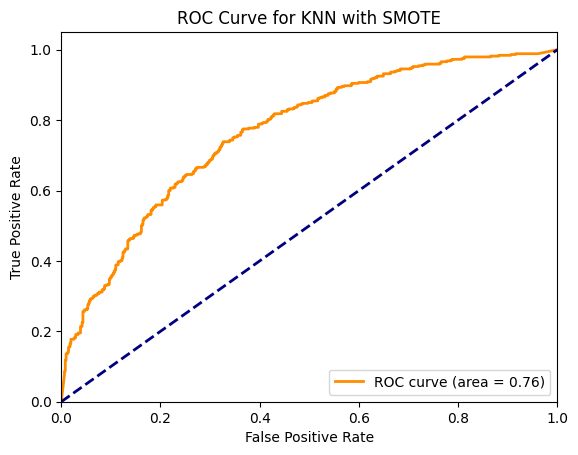

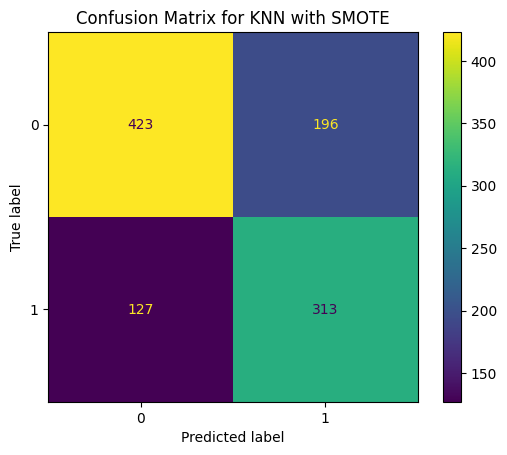

Model saved as LogisticRegression.pkl


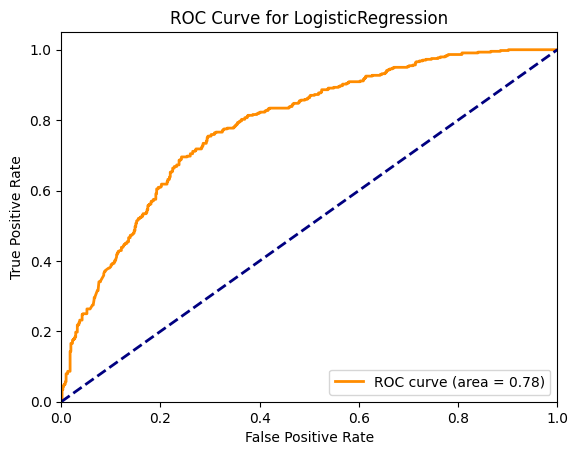

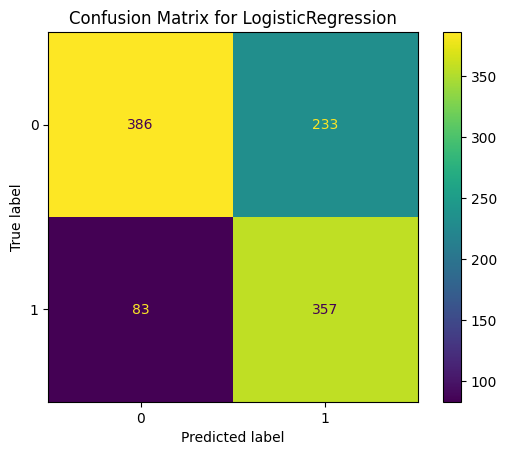

Model saved as LogisticRegression_with_SMOTE.pkl


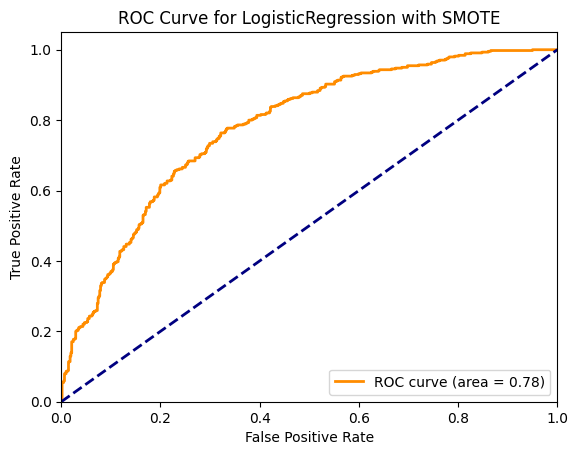

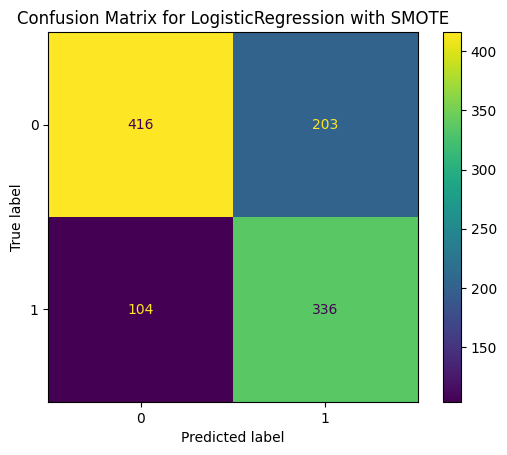

Model saved as RandomForest.pkl


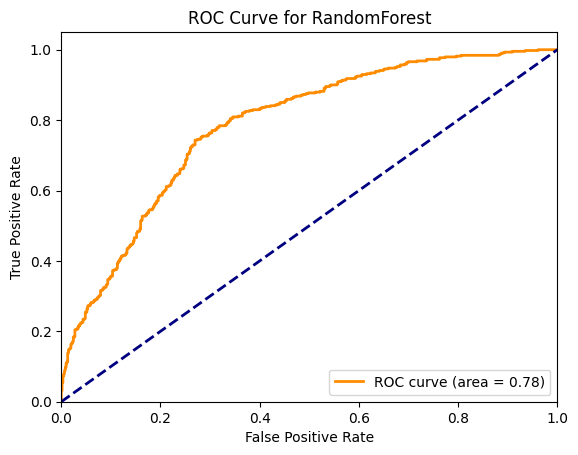

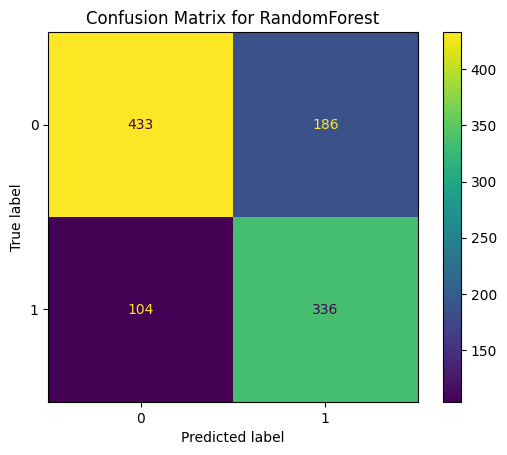

Model saved as RandomForest_with_SMOTE.pkl


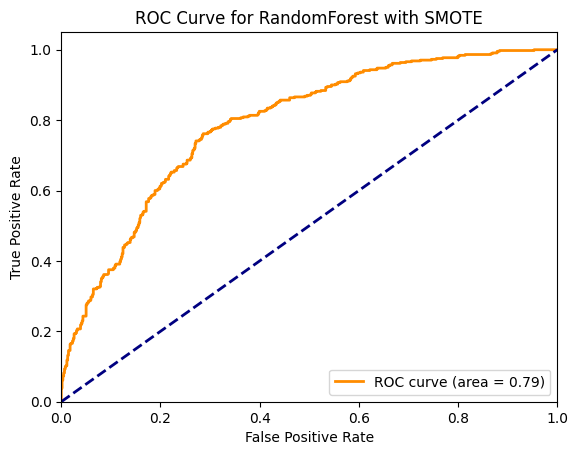

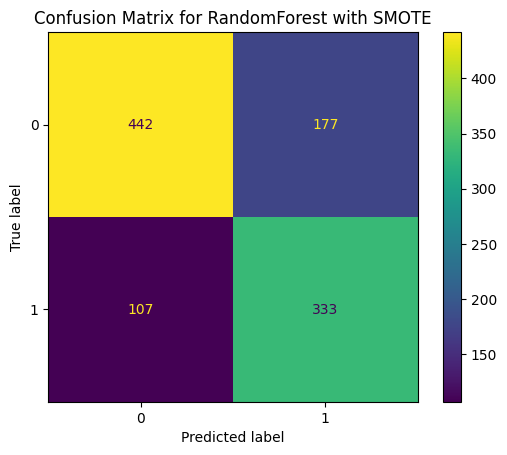

Model saved as XGBoost.pkl


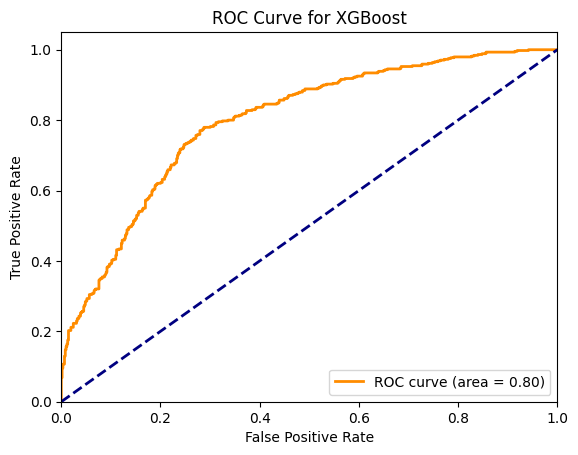

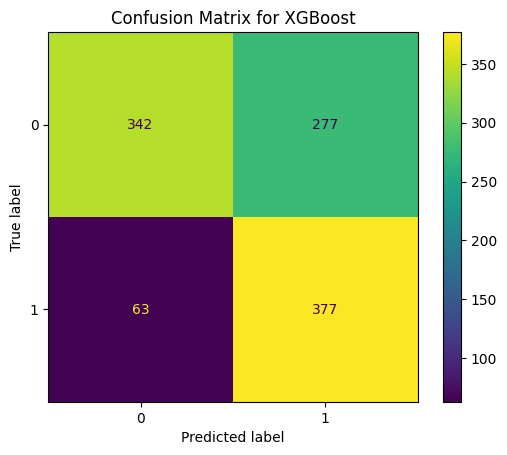

Model saved as XGBoost_with_SMOTE.pkl


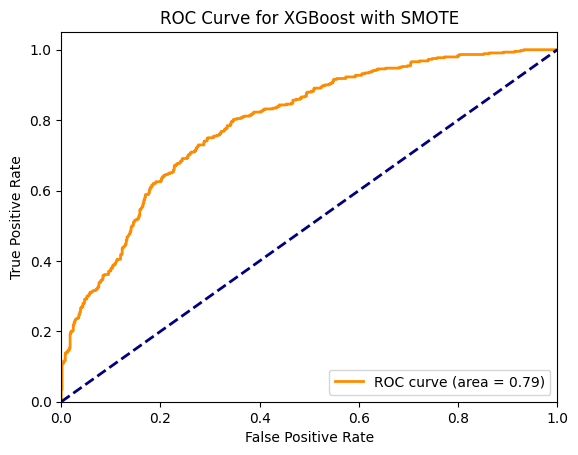

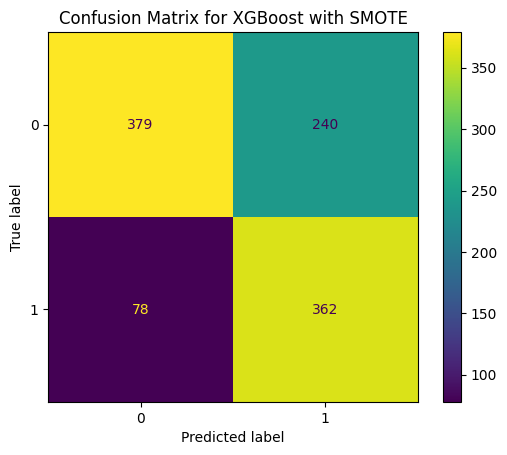

,accuracy,recall,precision,f1,AUC,best_cross_val_score
KNN,0.706327,0.611364,0.657702,0.633687,0.782879,0.642123
KNN With Smote,0.694995,0.711364,0.614931,0.659642,0.764921,0.676299
Logistic Regression,0.701605,0.811364,0.605085,0.693204,0.784397,0.687211
Logistic Regression With Smote,0.710104,0.763636,0.623377,0.686415,0.781060,0.685079
Random Forest,0.726157,0.763636,0.643678,0.698545,0.784730,0.697048
Random Forest With Smote,0.731822,0.756818,0.652941,0.701053,0.789033,0.697605
XGBoost,0.678942,0.856818,0.576453,0.689214,0.796870,0.704833
XGBoost With Smote,0.699717,0.822727,0.601329,0.694818,0.791794,0.709674


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.experimental import enable_iterative_imputer

from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Utility function to train and log models
def train_and_log_model(classifier, params, model_name, use_smote=False):

    # Set random_state to 42 if the classifier has this parameter
    if "random_state" in classifier.get_params().keys():
        classifier.set_params(random_state=42)

    steps = [
        ('imputer', IterativeImputer()),
        ('scaler', StandardScaler()),
        (model_name, classifier)
        ]
    
    if use_smote:
        steps.insert(1, ('smote', SMOTE(random_state=42)))
        model_name += ' with SMOTE'
        
    pipeline = ImbPipeline(steps) if use_smote else Pipeline(steps)

    kf = KFold(n_splits=5, random_state=42, shuffle=True)
    model = RandomizedSearchCV(pipeline, param_distributions=params, n_iter=50, cv=kf, scoring='f1', random_state=42)
    model.fit(X_train, y_train)

    model_filename = f'{model_name.replace(" ", "_")}.pkl'
    joblib.dump(model.best_estimator_, model_filename)
    print(f'Model saved as {model_filename}')

    # Make predictions and calculate metrics
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_probs) if y_pred_probs is not None else None,
        "best_cross_val_score": model.best_score_
    }

    # Calculate ROC Curve and AUC
    if y_pred_probs is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve for {model_name}')
        plt.legend(loc="lower right")
        plt.show()

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    return metrics

# Define model parameters
knn_params = {
    'KNN__n_neighbors': np.arange(1, 31, 3),
    'KNN__weights': ['uniform', 'distance'],
    'KNN__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

logreg_params = {
    'LogisticRegression__C': [0.01, 0.1, 1, 10],
    'LogisticRegression__penalty': ['l1', 'l2'],
    'LogisticRegression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'LogisticRegression__max_iter': [100, 500, 1000],
    'LogisticRegression__class_weight': [None, 'balanced'],
    'LogisticRegression__fit_intercept': [True, False]
}

svc_params = {
    'Support_Vector_Classifier__C': [0.1, 1, 10, 100],
    'Support_Vector_Classifier__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'Support_Vector_Classifier__gamma': [0.1, 1, 'auto', 'scale'],
    'Support_Vector_Classifier__class_weight': [None, 'balanced'],
    'Support_Vector_Classifier__probability': [True]
}

rf_params = {
    'RandomForest__n_estimators': [10, 50, 100, 200, 300, 500],
    'RandomForest__criterion': ['gini', 'entropy'],
    'RandomForest__max_depth': [None, 3, 5, 7, 10, 20, 30],
    'RandomForest__min_samples_split': [2, 5, 10],
    'RandomForest__min_samples_leaf': [1, 2, 4],
    'RandomForest__bootstrap': [True, False],
    'RandomForest__class_weight': [None, 'balanced']
}

scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

xgb_params = {
    'XGBoost__learning_rate': [None, 0.001, 0.01, 0.1],
    'XGBoost__n_estimators': [50, 100, 200],
    'XGBoost__max_depth': [None, 3, 5, 7],
    'XGBoost__subsample': [0.8, 0.9, 1.0],
    'XGBoost__colsample_bytree': [0.7, 0.8, 0.9],
    'XGBoost__gamma': [0.1, 0.2],
    'XGBoost__lambda': [0.1, 1.0],
    'XGBoost__alpha': [0.1, 1.0],
    'XGBoost__scale_pos_weight': [3, 4, 5, scale_pos_weight],
    'XGBoost__max_delta_step': [1, 2, 5, 10]
}

# Store results
results = {}

# Train models and store results
results['KNN'] = train_and_log_model(KNeighborsClassifier(), knn_params, 'KNN')
results['KNN With Smote'] = train_and_log_model(KNeighborsClassifier(), knn_params, 'KNN', use_smote=True)

results['Logistic Regression'] = train_and_log_model(LogisticRegression(), logreg_params, 'LogisticRegression')
results['Logistic Regression With Smote'] = train_and_log_model(LogisticRegression(), logreg_params, 'LogisticRegression', use_smote=True)

# results['SVC'] = train_and_log_model(SVC(), svc_params, 'Support_Vector_Classifier')
# results['SVC With Smote'] = train_and_log_model(SVC(), svc_params, 'Support_Vector_Classifier', use_smote=True)

results['Random Forest'] = train_and_log_model(RandomForestClassifier(), rf_params, 'RandomForest')
results['Random Forest With Smote'] = train_and_log_model(RandomForestClassifier(), rf_params, 'RandomForest', use_smote=True)

results['XGBoost'] = train_and_log_model(xgb.XGBClassifier(), xgb_params, 'XGBoost')
results['XGBoost With Smote'] = train_and_log_model(xgb.XGBClassifier(), xgb_params, 'XGBoost', use_smote=True)

results_df = pd.DataFrame(results).T
results_df

### Código para cargar modelos

In [2]:
import joblib

# Function to load a model
def load_model(model_filename):
    return joblib.load(model_filename)

# Example usage for each model
loaded_knn_model = load_model('KNN.pkl')
loaded_knn_with_smote_model = load_model('KNN_with_SMOTE.pkl')
loaded_logistic_regression_model = load_model('LogisticRegression.pkl')
loaded_logistic_regression_with_smote_model = load_model('LogisticRegression_with_SMOTE.pkl')
loaded_random_forest_model = load_model('RandomForest.pkl')
loaded_random_forest_with_smote_model = load_model('RandomForest_with_SMOTE.pkl')
loaded_xgboost_model = load_model('XGBoost.pkl')
loaded_xgboost_with_smote_model = load_model('XGBoost_with_SMOTE.pkl')


### verificar la calidad del archivo .pkl calculando métricas de un modelo

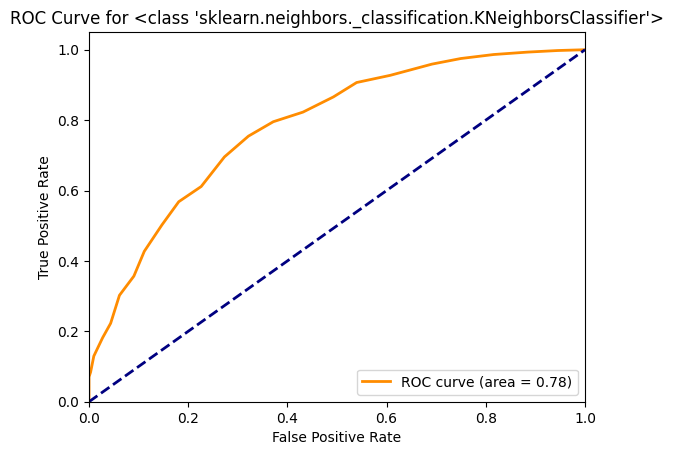

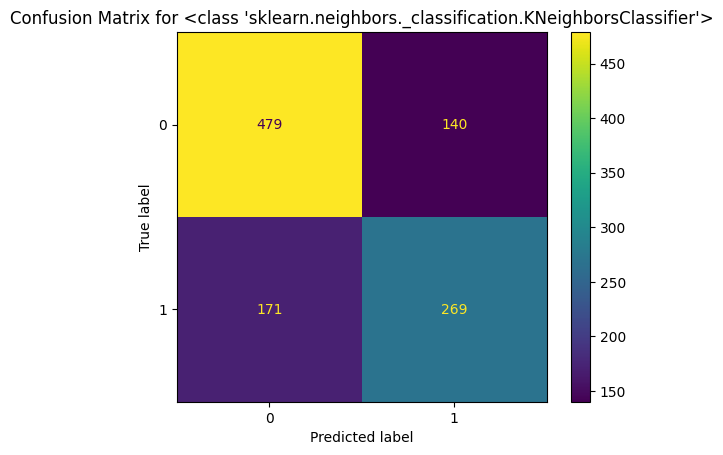

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

model = loaded_knn_model

classifier = model

model_name = str(model.steps[-1][1].__class__)

# Make predictions and calculate metrics
y_pred = model.predict(X_test)
y_pred_probs = model.predict_proba(X_test)[:, 1] if hasattr(classifier, "predict_proba") else None
metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_probs) if y_pred_probs is not None else None,
}

# Calculate ROC Curve and AUC
if y_pred_probs is not None:
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title(f'Confusion Matrix for {model_name}')
plt.show()